# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

warnings.filterwarnings("ignore")

2024-07-16 18:56:18.691068: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 18:56:18.815516: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 18:56:18.971110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 18:56:19.095198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 18:56:19.095862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 18:56:19.438610: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [4]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'NW_risk'

In [5]:
nr_common_PCs = 25
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
nr_rare_PCs = 25
rare_pc_columns = ['PC{}'.format(i) for i in range(1, nr_rare_PCs+1)]

In [6]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [7]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# Load environmental risk

In [8]:
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")

# Create phenotype only ENV dependent

In [9]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
precision = 0.1
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), precision))
risk['pheno'] = y
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

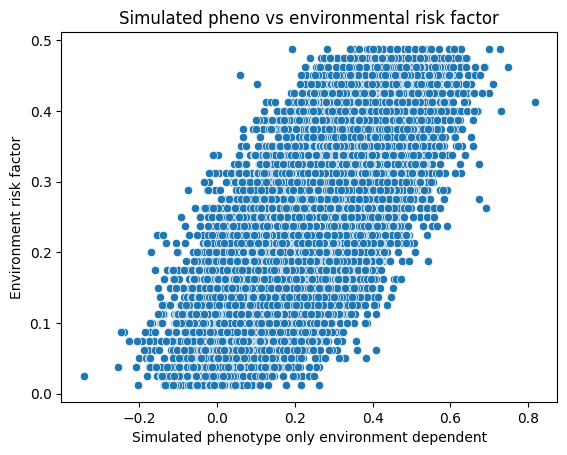

In [10]:
sns.scatterplot(x=list(y), y=list(np.array(risk[name_risk])))
plt.xlabel('Simulated phenotype only environment dependent')
plt.ylabel('Environment risk factor')
plt.title('Simulated pheno vs environmental risk factor')
plt.show()

# Analysis

In [11]:
# No correction
df_no_corr = manhattan_linear(complete, risk[['pheno']])

Global phenotype
No Covs!


In [12]:
# rare PCA
PC_veryrare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
df_rare_PCs = manhattan_linear(complete, y , PC_veryrare[rare_pc_columns])

Pheno is not None and not a dataframe
Covs


In [13]:
# PCA
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = manhattan_linear(complete, y , PC_common[rare_pc_columns])

Pheno is not None and not a dataframe
Covs


In [14]:
# Genomic control
df_GC = gc(df_no_corr)

In [15]:
# minimalist abyss
bottleneck_nr = 20
epoch = 300
patience = 20
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(complete*2 - 1, bottleneck_nr, epoch, patience)
# Extract the bottleneck layer after fitting the model
bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)

abyss_bottle = bottleneck_model(tf.convert_to_tensor(complete, dtype=tf.float32))
abyss_bottleneck = pd.DataFrame(data=abyss_bottle, columns = dim_columns)

abyss_MAF = autoencoder(tf.convert_to_tensor(complete, dtype=tf.float32))
p = (pd.DataFrame(data=abyss_MAF, columns = complete.columns)+1)/2

df_abyss_maf = manhattan_linear(complete, y, p)
df_abyss_bottle = manhattan_linear(complete, y, abyss_bottleneck)

Pheno is not None and not a dataframe
Abyss!
Pheno is not None and not a dataframe
Covs


In [16]:
# deep abyss
bottleneck_nr = 20
epoch = 300
patience = 20
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]

deep_autoencoder, deep_bottleneck_model, deep_history = deep_abyss(complete, bottleneck_nr, epoch, patience, risk[['pheno']])
[deep_abyss_MAF, deep_abyss_pred] = deep_autoencoder(tf.convert_to_tensor(complete, dtype=tf.float32))
deep_abyss_bottle = deep_bottleneck_model(tf.convert_to_tensor(complete, dtype=tf.float32))

p_deep = (pd.DataFrame(data=deep_abyss_MAF, columns = complete.columns)+1)/2
deep_abyss_bottleneck = pd.DataFrame(data=deep_abyss_bottle, columns = dim_columns)
deep_abyss_prediction = pd.DataFrame(data=deep_abyss_pred, columns = ["prediction"])

df_deep_abyss_bottle = manhattan_linear(complete, y, deep_abyss_bottleneck)
df_deep_abyss_maf = manhattan_linear(complete, y, p_deep)
df_deep_abyss_pred = manhattan_linear(complete, y, deep_abyss_prediction)

Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Abyss!
Pheno is not None and not a dataframe
Covs


In [17]:
# deep abyss genotype correction
df_deep_abyss_genocorr = manhattan_linear(complete - (p_deep-(1-p_deep)), risk['pheno'] - deep_abyss_prediction['prediction'])

Pheno is not None and not a dataframe
No Covs!


In [18]:
# Create QQ plot
df_qq_plot = pd.DataFrame()
df_qq_plot["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
df_qq_plot["-logP_rare_PCs"] = np.sort(df_rare_PCs['-logPs'])
df_qq_plot["-logP_common_PCs"] = np.sort(df_PCs['-logPs'])
df_qq_plot["-logP_GC"] = np.sort(df_GC['-logPs'])
df_qq_plot["-logP_abyss_bottle"] = np.sort(df_abyss_bottle['-logPs'])
df_qq_plot["-logP_abyss_maf"] = np.sort(df_abyss_maf['-logPs'])
df_qq_plot["-logP_deep_abyss_bottle"] = np.sort(df_deep_abyss_bottle['-logPs'])
df_qq_plot["-logP_deep_abyss_maf"] = np.sort(df_deep_abyss_maf['-logPs'])
df_qq_plot["-logP_deep_abyss_pred"] = np.sort(df_deep_abyss_pred['-logPs'])
df_qq_plot["-logP_deep_abyss_genocorr"] = np.sort(df_deep_abyss_genocorr['-logPs'])
# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_qq_plot.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_qq_plot.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_qq_plot.fillna(max_value, inplace=True)
n = len(df_qq_plot)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_qq_plot['expected_logP'] = expected_logP

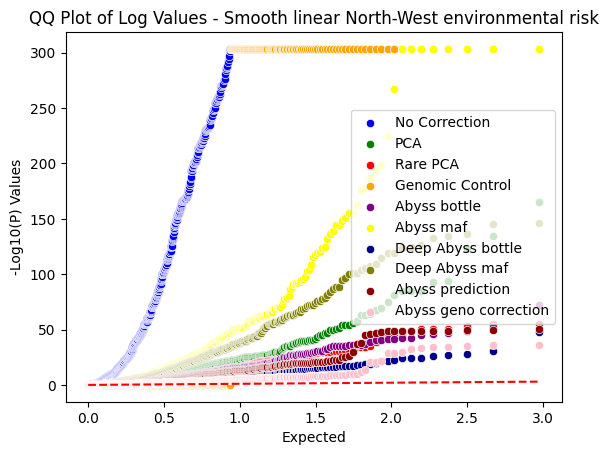

In [19]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_qq_plot, color='blue', label='No Correction')

sns.scatterplot(x='expected_logP', y='-logP_common_PCs', data=df_qq_plot, color='green', label='PCA')

sns.scatterplot(x='expected_logP', y='-logP_rare_PCs', data=df_qq_plot, color='red', label='Rare PCA')

sns.scatterplot(x='expected_logP', y='-logP_GC', data=df_qq_plot, color='orange', label='Genomic Control')

sns.scatterplot(x='expected_logP', y='-logP_abyss_bottle', data=df_qq_plot, color='purple', label='Abyss bottle')

sns.scatterplot(x='expected_logP', y='-logP_abyss_maf', data=df_qq_plot, color='yellow', label='Abyss maf')

sns.scatterplot(x='expected_logP', y='-logP_deep_abyss_bottle', data=df_qq_plot, color='darkblue', label='Deep Abyss bottle')

sns.scatterplot(x='expected_logP', y='-logP_deep_abyss_maf', data=df_qq_plot, color='olive', label='Deep Abyss maf')

sns.scatterplot(x='expected_logP', y='-logP_deep_abyss_pred', data=df_qq_plot, color='darkred', label='Abyss prediction')

sns.scatterplot(x='expected_logP', y='-logP_deep_abyss_genocorr', data=df_qq_plot, color='pink', label='Abyss geno correction')


# Plot diagonal reference line
plt.plot([min(df_qq_plot['expected_logP']), max(df_qq_plot['expected_logP'])], 
         [min(df_qq_plot['expected_logP']), max(df_qq_plot['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

In [20]:
#df_rare_PCs.rename(columns={col: col + '_rare_PCs' for col in df_rare_PCs.columns if col != 'snp'}, inplace=True)

In [21]:
# risk as covariate
df_risk_as_cov = manhattan_linear(complete, y , risk[[name_risk]])

Pheno is not None and not a dataframe
Covs


In [22]:
df_pheno_as_cov = manhattan_linear(complete, y , pd.DataFrame(data=y, columns=["pheno"]))

Pheno is not None and not a dataframe
Covs


In [23]:
df_bottlecorrection = manhattan_linear(complete - (p_deep-(1-p_deep)), y , deep_abyss_bottleneck)

Pheno is not None and not a dataframe
Covs


In [24]:
col_names = []
covariate_dictionary = {}

for element in p.columns:
    temp = p[[element]].copy()
    temp[f"{element}_cov"] = temp[element] - (1 - temp[element])
    for col in deep_abyss_bottleneck.columns:
        temp[col] = deep_abyss_bottleneck[col]

    temp = temp.drop(columns=[element])
    covariate_dictionary[element] = temp

In [25]:
df_bottlecorrection = manhattan_linear(complete, y , covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [26]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_GC"] = np.sort(df_GC['-logPs'])
df_bests["-logP_deep_abyss_bottle"] = np.sort(df_deep_abyss_bottle['-logPs'])
df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])
df_bests["-logP_risk_as_cov"] = np.sort(df_risk_as_cov['-logPs'])
df_bests["-logP_pheno_as_cov"] = np.sort(df_pheno_as_cov['-logPs'])
df_bests["-logP_deep_abyss_genocorr"] = np.sort(df_deep_abyss_genocorr['-logPs'])
df_bests["-logP_deep_abyss_bottlecorr"] = np.sort(df_bottlecorrection['-logPs'])



# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

In [1]:
sns.scatterplot(x='expected_logP', y='-logP_pheno_as_cov', data=df_bests, color='red', label='Pheno as covariate')

sns.scatterplot(x='expected_logP', y='-logP_risk_as_cov', data=df_bests, color='black', label='Risk as covariate')

#sns.scatterplot(x='expected_logP', y='-logP_GC', data=df_bests, color='orange', label='Genomic Control')

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='green', label='PCA')

sns.scatterplot(x='expected_logP', y='-logP_deep_abyss_bottle', data=df_bests, color='darkblue', label='Deep Abyss Bottle')


sns.scatterplot(x='expected_logP', y='-logP_deep_abyss_genocorr', data=df_bests, color='pink', label='Abyss geno correction')

sns.scatterplot(x='expected_logP', y='-logP_deep_abyss_bottlecorr', data=df_bests, color='purple', label='Abyss bottle correction')


# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

NameError: name 'sns' is not defined

In [28]:
estimated_AF = (1-p_deep).mean(axis=0)
AFs = [float(item.split('_')[-1]) for item in list(p_deep.columns)]

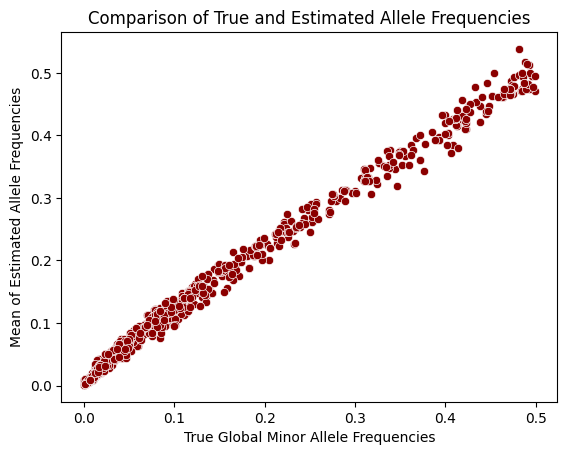

In [29]:
sns.scatterplot(x=AFs, y=list(estimated_AF), color = "darkred")
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies')
plt.show()

In [30]:
deep_abyss_prediction['prediction']

0        0.265218
1        0.263733
2        0.267221
3        0.265554
4        0.265218
           ...   
19995    0.269341
19996    0.268109
19997    0.284129
19998    0.284129
19999    0.277726
Name: prediction, Length: 20000, dtype: float32

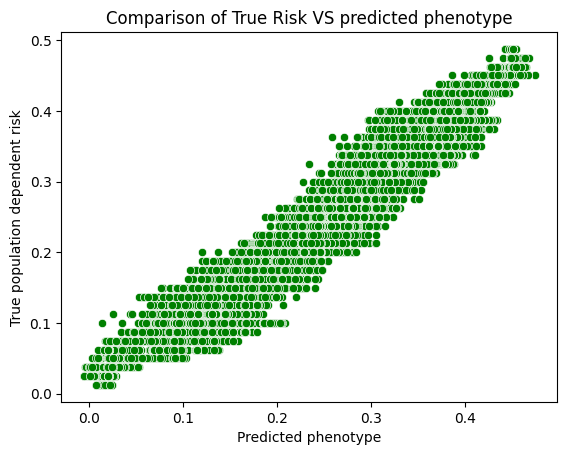

In [31]:
sns.scatterplot(x=deep_abyss_prediction['prediction'], y=risk[name_risk], color='green')
plt.xlabel('Predicted phenotype')
plt.ylabel('True population dependent risk')
plt.title('Comparison of True Risk VS predicted phenotype')
plt.show()

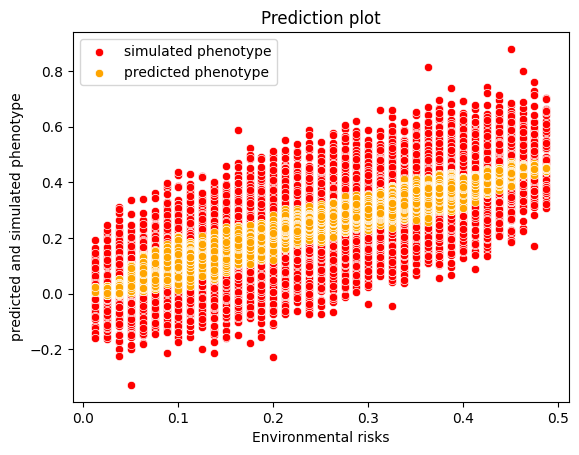

In [32]:
sns.scatterplot(x=risk[name_risk], y=y, color='red', label='simulated phenotype')

sns.scatterplot(x=risk[name_risk], y=deep_abyss_prediction['prediction'], color='orange', label='predicted phenotype')

# Set plot labels and title
plt.xlabel('Environmental risks')
plt.ylabel('predicted and simulated phenotype')
plt.title(f"Prediction plot")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# Check output of everything

In [33]:
bottle_df = pd.DataFrame(deep_abyss_bottle, columns=dim_columns)
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle_df[to_have_collumns] = populations[to_have_collumns]

In [34]:

# Function to calculate entropy of a column
def calculate_entropy(column):
    counts = column.value_counts()
    return entropy(counts)

temp = bottle_df.round(2)
# Calculate entropy for each column
entropy_values = temp.apply(calculate_entropy)

# Rank the columns based on entropy
ranked_columns_entropy = entropy_values.sort_values(ascending=False)
most_explaining_dims = list(ranked_columns_entropy.keys())
most_explaining_dims = [f for f in most_explaining_dims if f.startswith('dim')]

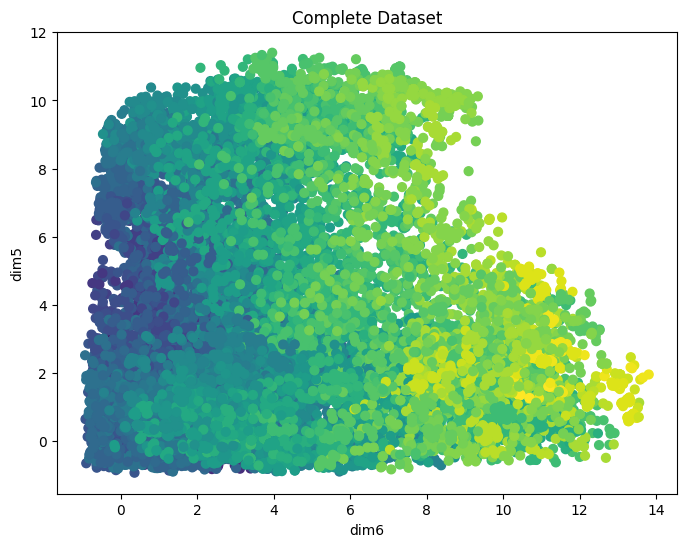

In [35]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = list(risk[name_risk])
plt.scatter(x=bottle_df[most_explaining_dims[0]], y=bottle_df[most_explaining_dims[1]], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[0]}")
plt.ylabel(f"{most_explaining_dims[1]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

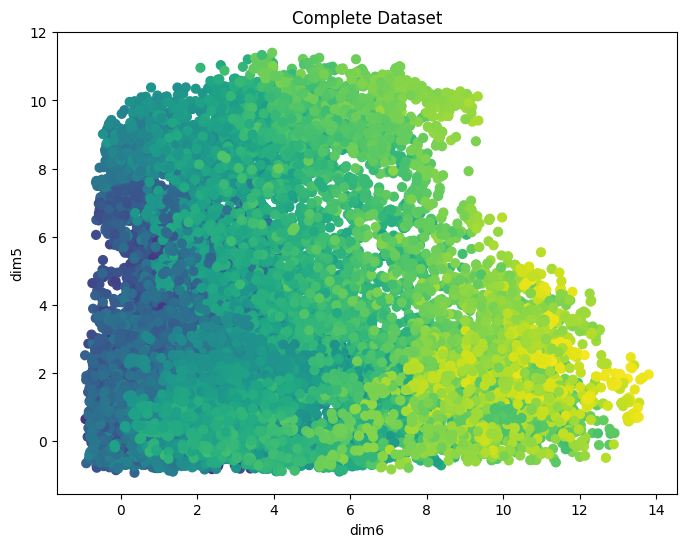

In [36]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = list(deep_abyss_prediction['prediction'])
plt.scatter(x=bottle_df[most_explaining_dims[0]], y=bottle_df[most_explaining_dims[1]], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[0]}")
plt.ylabel(f"{most_explaining_dims[1]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

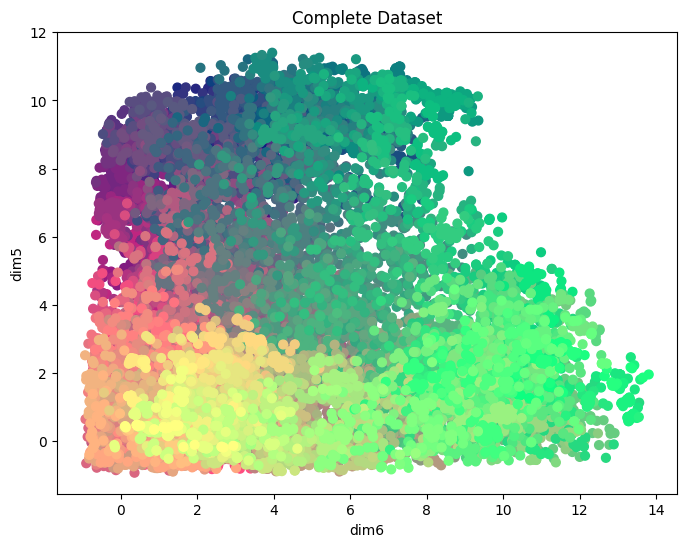

In [37]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[0]], y=bottle_df[most_explaining_dims[1]], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[0]}")
plt.ylabel(f"{most_explaining_dims[1]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

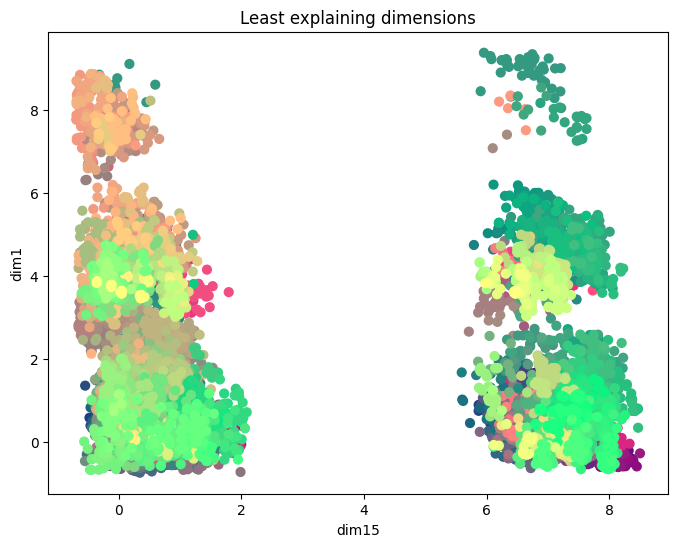

In [38]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[-1]], y=bottle_df[most_explaining_dims[-2]], c=colors, s=40)

plt.title('Least explaining dimensions')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[-1]}")
plt.ylabel(f"{most_explaining_dims[-2]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()